<a href="https://colab.research.google.com/github/angadbajwa23/Image-Background-Remover/blob/master/IMGBGR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
%cd gdrive/My Drive

/content/gdrive/My Drive


In [0]:
!wget http://download.tensorflow.org/models/deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz


--2020-05-29 07:39:41--  http://download.tensorflow.org/models/deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 74.125.71.128, 2a00:1450:400c:c02::80
Connecting to download.tensorflow.org (download.tensorflow.org)|74.125.71.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23882985 (23M) [application/x-tar]
Saving to: ‘deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz’

deeplabv3_mnv2_pasc 100%[===================>]  22.78M  38.5MB/s    in 0.6s    

2020-05-29 07:39:42 (38.5 MB/s) - ‘deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz’ saved [23882985/23882985]



In [0]:
!wget http://download.tensorflow.org/models/deeplabv3_pascal_train_aug_2018_01_04.tar.gz

--2020-05-29 07:39:54--  http://download.tensorflow.org/models/deeplabv3_pascal_train_aug_2018_01_04.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 74.125.71.128, 2a00:1450:400c:c02::80
Connecting to download.tensorflow.org (download.tensorflow.org)|74.125.71.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 460058541 (439M) [application/x-tar]
Saving to: ‘deeplabv3_pascal_train_aug_2018_01_04.tar.gz’

deeplabv3_pascal_tr 100%[===================>] 438.75M  39.6MB/s    in 12s     

2020-05-29 07:40:07 (35.7 MB/s) - ‘deeplabv3_pascal_train_aug_2018_01_04.tar.gz’ saved [460058541/460058541]



In [0]:
!mkdir mobile_net_model

In [0]:
!mkdir xception_model

In [0]:
!tar xvzf deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz -C mobile_net_model --strip=1

deeplabv3_mnv2_pascal_train_aug/model.ckpt-30000.index
deeplabv3_mnv2_pascal_train_aug/frozen_inference_graph.pb
deeplabv3_mnv2_pascal_train_aug/model.ckpt-30000.data-00000-of-00001


In [0]:
!tar xvzf deeplabv3_pascal_train_aug_2018_01_04.tar.gz -C xception_model --strip=1

deeplabv3_pascal_train_aug/model.ckpt.index
deeplabv3_pascal_train_aug/frozen_inference_graph.pb
deeplabv3_pascal_train_aug/model.ckpt.data-00000-of-00001


In [0]:
!rm deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz
!rm deeplabv3_pascal_train_aug_2018_01_04.tar.gz

In [0]:
import os
from io import BytesIO

import numpy as np
from PIL import Image

import tensorflow as tf
import sys
import datetime
import matplotlib.pyplot as plt



class DeepLabModel(object):
  """Class to load deeplab model and run inference."""

  INPUT_TENSOR_NAME = 'ImageTensor:0'
  OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
  INPUT_SIZE = 513
  FROZEN_GRAPH_NAME = 'frozen_inference_graph'

  def __init__(self, tarball_path):
    """Creates and loads pretrained deeplab model."""
    self.graph = tf.Graph()

    graph_def = None
    graph_def = tf.compat.v1.GraphDef.FromString(open(tarball_path + "/frozen_inference_graph.pb", "rb").read()) 


    if graph_def is None:
      raise RuntimeError('Cannot find inference graph in tar archive.')

    with self.graph.as_default():
      tf.import_graph_def(graph_def, name='')

    self.sess = tf.compat.v1.Session(graph=self.graph)

  def run(self, image):
    """Runs inference on a single image.
    Args:
      image: A PIL.Image object, raw input image.
    Returns:
      resized_image: RGB image resized from original input image.
      seg_map: Segmentation map of `resized_image`.
    """
    start = datetime.datetime.now()

    width, height = image.size
    resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
    target_size = (int(resize_ratio * width), int(resize_ratio * height))
    resized_image = image.convert('RGB').resize(target_size, Image.ANTIALIAS)
    batch_seg_map = self.sess.run(
        self.OUTPUT_TENSOR_NAME,
        feed_dict={self.INPUT_TENSOR_NAME: [np.asarray(resized_image)]})
    seg_map = batch_seg_map[0]

    end = datetime.datetime.now()

    diff = end - start
    print("Time taken to evaluate segmentation is : " + str(diff))

    return resized_image, seg_map

def drawSegment(baseImg, matImg):
  width, height = baseImg.size
  dummyImg = np.zeros([height, width, 4], dtype=np.uint8)
  for x in range(width):
            for y in range(height):
                color = matImg[y,x]
                (r,g,b) = baseImg.getpixel((x,y))
                if color == 0:
                    dummyImg[y,x,3] = 0
                else :
                    dummyImg[y,x] = [r,g,b,255]
  img = Image.fromarray(dummyImg)
  plt.figure(figsize=(12, 10))
  plt.subplot(221)
  plt.imshow(baseImg)
  plt.subplot(222)
  plt.imshow(img)


inputFilePath = sys.argv[1]
outputFilePath = sys.argv[2]

if inputFilePath is None or outputFilePath is None:
  print("Bad parameters. Please specify input file path and output file path")
  exit()

modelType = "mobile_net_model"
if len(sys.argv) > 3 and sys.argv[3] == "1":
  modelType = "xception_model"

MODEL = DeepLabModel(modelType)
print('model loaded successfully : ' + modelType)

def run_visualization(filepath):
  """Inferences DeepLab model and visualizes result."""
  try:
  	print("Trying to open : " + sys.argv[1])
  	# f = open(sys.argv[1])
  	jpeg_str = open(filepath, "rb").read()
  	orignal_im = Image.open(BytesIO(jpeg_str))
  except IOError:
    print('Cannot retrieve image. Please check file: ' + filepath)
    return

  print('running deeplab on image %s...' % filepath)
  resized_im, seg_map = MODEL.run(orignal_im)

  # vis_segmentation(resized_im, seg_map)
  drawSegment(resized_im, seg_map)



model loaded successfully : mobile_net_model


Trying to open : -f
running deeplab on image /content/gdrive/My Drive/sample.jpg...
Time taken to evaluate segmentation is : 0:00:00.406341


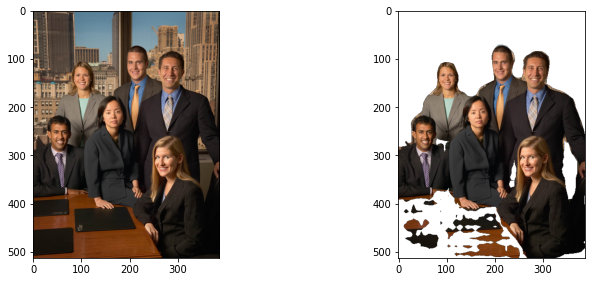

In [0]:
run_visualization('/content/gdrive/My Drive/sample.jpg')

Trying to open : -f
running deeplab on image /content/gdrive/My Drive/girl.jfif...
Time taken to evaluate segmentation is : 0:00:00.032637


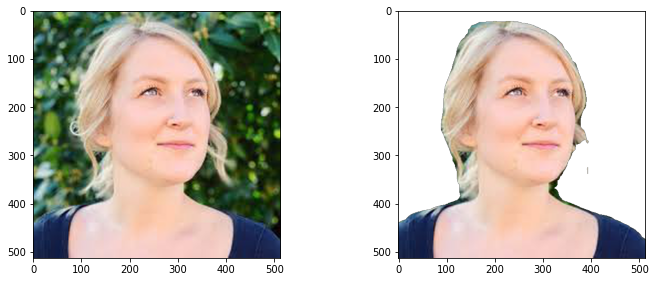

In [0]:
run_visualization('/content/gdrive/My Drive/girl.jfif')

Trying to open : -f
running deeplab on image /content/gdrive/My Drive/horses.jfif...
Time taken to evaluate segmentation is : 0:00:00.027518


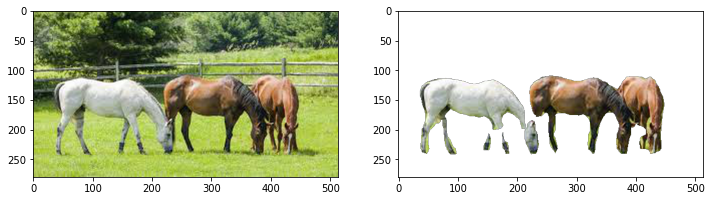

In [0]:
run_visualization('/content/gdrive/My Drive/horses.jfif')

Trying to open : -f
running deeplab on image /content/gdrive/My Drive/rider.jfif...
Time taken to evaluate segmentation is : 0:00:00.027795


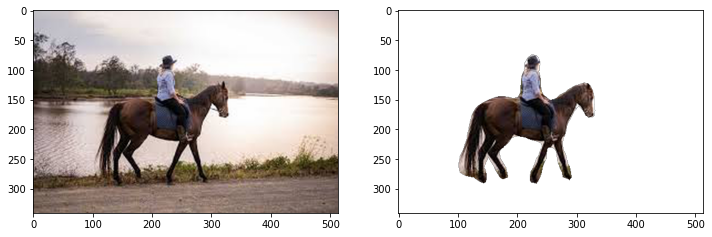

In [0]:
run_visualization('/content/gdrive/My Drive/rider.jfif')

Trying to open : -f
running deeplab on image /content/gdrive/My Drive/car.jpg...
Time taken to evaluate segmentation is : 0:00:00.044745


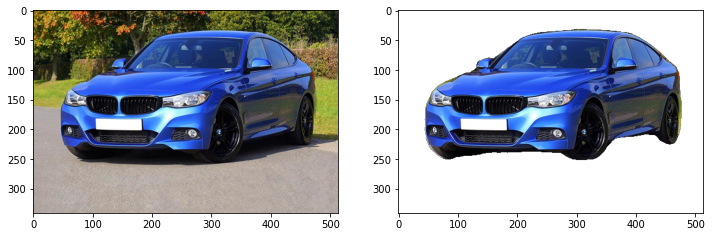

In [0]:
run_visualization('/content/gdrive/My Drive/car.jpg')

Trying to open : -f
running deeplab on image /content/gdrive/My Drive/bird.png...
Time taken to evaluate segmentation is : 0:00:00.031703


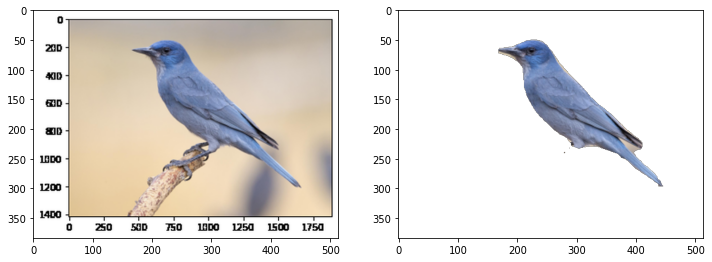

In [0]:
run_visualization('/content/gdrive/My Drive/bird.png')